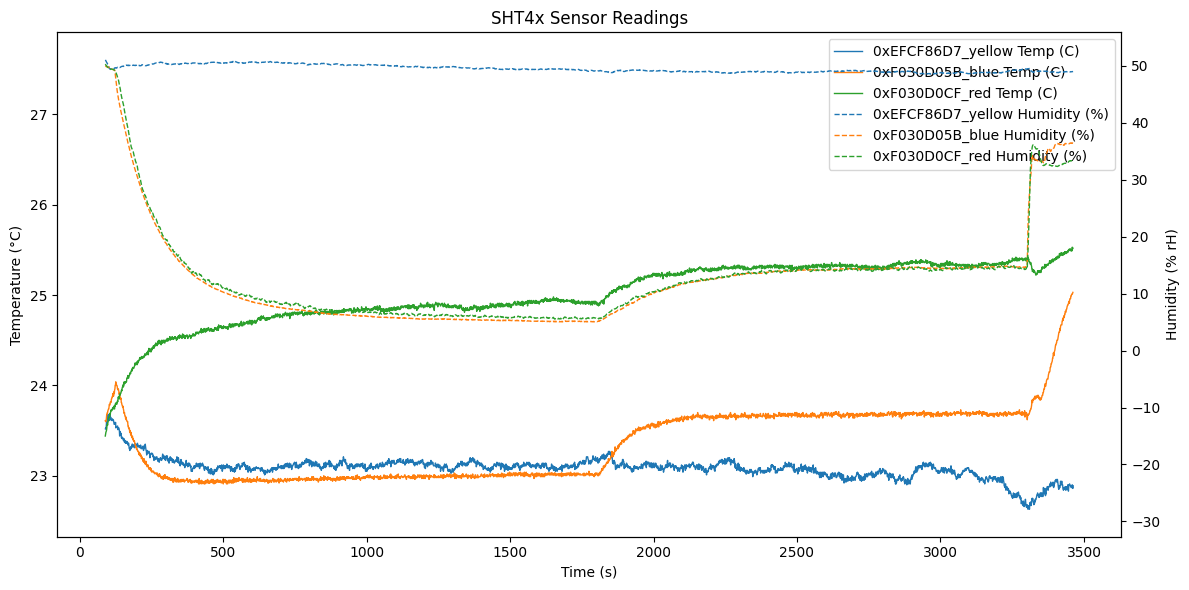

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

csv_file = 'sensor_readings_20250627_121615.csv'
df = pd.read_csv(csv_file)
df['time_s'] = df['timestamp'] / 1000.0

# Function to calculate absolute humidity (g/m³)
def calc_absolute_humidity(temp_c, rh):
    # Formula: AH = 6.112 * exp((17.67*T)/(T+243.5)) * RH * 2.1674 / (273.15+T)
    # T in °C, RH in %, AH in g/m³
    return 6.112 * np.exp((17.67 * temp_c) / (temp_c + 243.5)) * rh * 2.1674 / (273.15 + temp_c) / 100


serials = set()
for col in df.columns:
    if '_temperature' in col:
        serials.add(col.replace('_temperature (degrees C)', ''))

plt.figure(figsize=(12, 6))
ax1 = plt.gca()
ax2 = ax1.twinx()

for serial in serials:
    temp_col = f"{serial}_temperature (degrees C)"
    hum_col = f"{serial}_humidity (% rH)"
    # Plot only where data exists (drop NaNs)
    temp_data = df[['time_s', temp_col]].dropna()
    hum_data = df[['time_s', hum_col]].dropna()
    ax1.plot(temp_data['time_s'], temp_data[temp_col], label=f"{serial} Temp (C)", linewidth=1)
    ax2.plot(hum_data['time_s'], hum_data[hum_col], linestyle='--', label=f"{serial} Humidity (%)", linewidth=1)

ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Temperature (°C)')
ax2.set_ylabel('Humidity (% rH)')
ax1.set_title('SHT4x Sensor Readings')

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

temp_dynamic_range = ax1.get_ylim()[1] - ax1.get_ylim()[0]
rh_dynamic_range = ax2.get_ylim()[1] - ax2.get_ylim()[0]

ax1.set_ylim(ax1.get_ylim()[0] - 0.05 * temp_dynamic_range, ax1.get_ylim()[1] + 0.7 * temp_dynamic_range)
ax2.set_ylim(ax2.get_ylim()[0] - 0.7 * rh_dynamic_range, ax2.get_ylim()[1] + 0.05 * rh_dynamic_range)

plt.tight_layout()
plt.show()

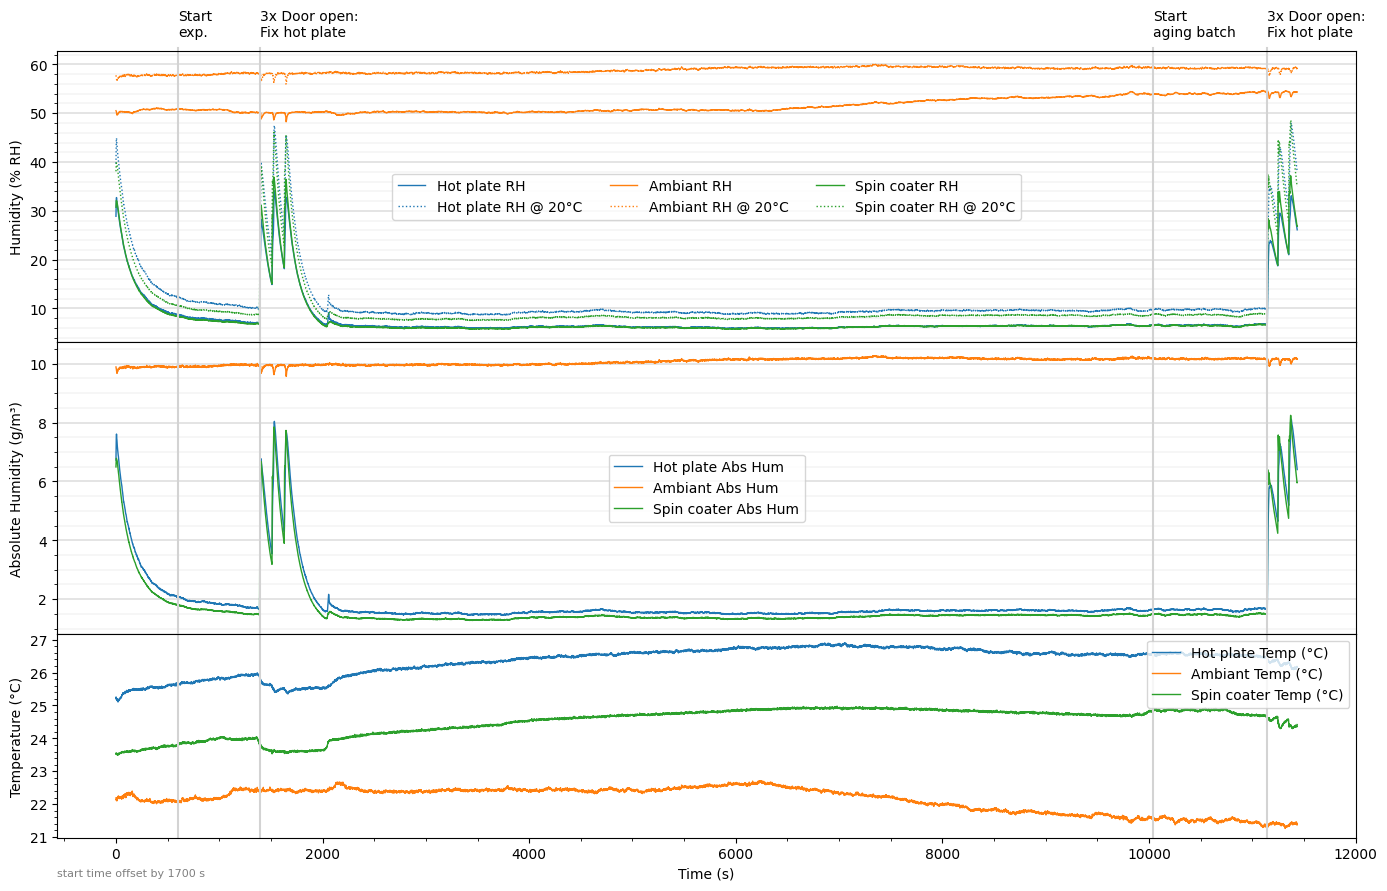

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

csv_file = 'sensor_readings_20250709_101706.csv'
start_time_offeset = 1700  # seconds to ignore at the start
time_unit = 's'  # time unit for x-axis, can be 's' or 'min'
serial_to_name = {
    "sensor_readings_20250620_125414.csv": {
        "0xF030D05B_blue": "Box",
        "0xF030D0CF_red": "House air",
        "0xEFCF86D7_yellow": "Ambiant"
    },
    "sensor_readings_20250623_140525.csv": {
        "0xF030D05B_blue": "Robot arm",
        "0xF030D0CF_red": "CBox carrier",
        "0xEFCF86D7_yellow": "Ambiant"
    },
    "sensor_readings_20250627_121615.csv": {
        "0xF030D05B_blue": "Robot arm",
        "0xF030D0CF_red": "Spin coater 2",
        "0xEFCF86D7_yellow": "Ambiant"
    },
    "sensor_readings_20250701_151456.csv": {
        "0xF030D05B_blue": "Hot plate",
        "0xF030D0CF_red": "Spin coater",
        "0xEFCF86D7_yellow": "Ambiant"
    },
    "sensor_readings_20250709_101706.csv": {
        "0xF030D05B_blue": "Hot plate",
        "0xF030D0CF_red": "Spin coater",
        "0xEFCF86D7_yellow": "Ambiant"
    }
}


def calc_absolute_humidity(temp_c, rh):
    # Ref: https://sensirion.com/media/documents/A419127A/6836C0D2/Sensirion_AppNotes_Humidity_Sensors_at_a_Glance.pdf
    return 216.7 * (rh / 100.0 * 6.112 * np.exp( 17.62 * temp_c / (243.12 + temp_c))/(273.15 + temp_c))

def calc_relative_humidity(rh, temp_c, target_temp_c):
    return rh * np.exp(4283.78 * (temp_c - target_temp_c) / (243.12 + temp_c) / (243.12 + target_temp_c))

df = pd.read_csv(csv_file)
df['time_s'] = df['timestamp'] / 1000.0

serials = set()
for col in df.columns:
    if '_temperature' in col:
        serials.add(col.replace('_temperature (degrees C)', ''))

data_series = {}
for i, serial in enumerate(serials):
    sensor_name = serial_to_name[csv_file].get(serial, serial)
    temp_col = f"{serial}_temperature (degrees C)"
    hum_col = f"{serial}_humidity (% rH)"
    valid = df[['time_s', temp_col, hum_col]].dropna()

    valid = valid[valid['time_s'] > start_time_offeset]
    valid['time_s'] -= valid['time_s'].min()  # Normalize time to start at 0

    valid = valid.assign(**{
        "Abs Hum (g/m³)": calc_absolute_humidity(valid[temp_col], valid[hum_col]),
        "RH @ 20°C (%)": calc_relative_humidity(valid[hum_col], valid[temp_col], 20.0),
        "time_min": valid['time_s'] / 60.0,
    })

    valid.rename(columns={
        temp_col: "T (°C)",
        hum_col: "RH (%)"
    }, inplace=True)

    data_series[sensor_name] = valid


fig, (ax_rh, ax_ah, ax_temp) = plt.subplots(
    3, 1, figsize=(14, 9), sharex=True, gridspec_kw={'height_ratios': [1, 1, 0.7], 'hspace': 0}
)

colors = mpl.cm.tab10(range(10))
for i, (sensor_name, data) in enumerate(data_series.items()):
    color = colors[i % len(colors)]
    x = data['time_s'] if time_unit == 's' else data['time_min']
    ax_ah.plot(x, data['Abs Hum (g/m³)'], label=f"{sensor_name} Abs Hum", color=color, linewidth=1, linestyle='-')
    ax_rh.plot(x, data['RH (%)'], label=f"{sensor_name} RH", linewidth=1, color=color, linestyle='-')
    ax_rh.plot(x, data['RH @ 20°C (%)'], label=f"{sensor_name} RH @ 20°C", linewidth=1, color=color, linestyle=':')
    ax_temp.plot(x, data['T (°C)'], label=f"{sensor_name} Temp (°C)", linewidth=1, color=color)

ax_ah.set_ylabel('Absolute Humidity (g/m³)')
ax_rh.set_ylabel('Humidity (% RH)')
ax_temp.set_ylabel('Temperature (°C)')

if time_unit == 's':
    ax_temp.set_xlabel('Time (s)')
elif time_unit == 'min':
    ax_temp.set_xlabel('Time (min)')
else:
    raise ValueError(f"Unsupported time unit: {time_unit}")


ax_temp.text(0, -0.15, f"start time offset by {start_time_offeset} s", 
             ha='left', va='top', fontsize=8, color='gray', transform=ax_temp.transAxes)
vlines = [
    ("Start\nexp.", 600),
    ("3x Door open:\nFix hot plate", 1390),
    ("Start\naging batch", 10040),
    ("3x Door open:\nFix hot plate", 11140),
]

for annotation, t, *kwargs in vlines:
    ax_ah.axvline(x=t, clip_on=False, color="lightgray")
    ax_rh.axvline(x=t, ymax=1.01, clip_on=False, color="lightgray")
    ax_temp.axvline(x=t, clip_on=False, color="lightgray")
    text_y_pos = ax_rh.get_ylim()[1] + (ax_rh.get_ylim()[1] - ax_rh.get_ylim()[0]) * 0.05
    ax_rh.text(t, text_y_pos, annotation, ha='left', ma='left', fontsize=10, clip_on=False)

ax_ah.legend()
ax_rh.legend(ncol=3)
ax_temp.legend()

ax_temp.minorticks_on()
ax_rh.minorticks_on()
ax_ah.minorticks_on()

ax_rh.grid(visible=True, which='major', axis='y', color='gray', linestyle='-', linewidth=0.3)
ax_rh.grid(visible=True, which='minor', axis='y', color='gray', linestyle='-', linewidth=0.1)

ax_ah.grid(visible=True, which='major', axis='y', color='gray', linestyle='-', linewidth=0.3)
ax_ah.grid(visible=True, which='minor', axis='y', color='gray', linestyle='-', linewidth=0.1)

plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.show()

# save the figure
fig.savefig(f'{csv_file}.png', dpi=300, bbox_inches='tight')

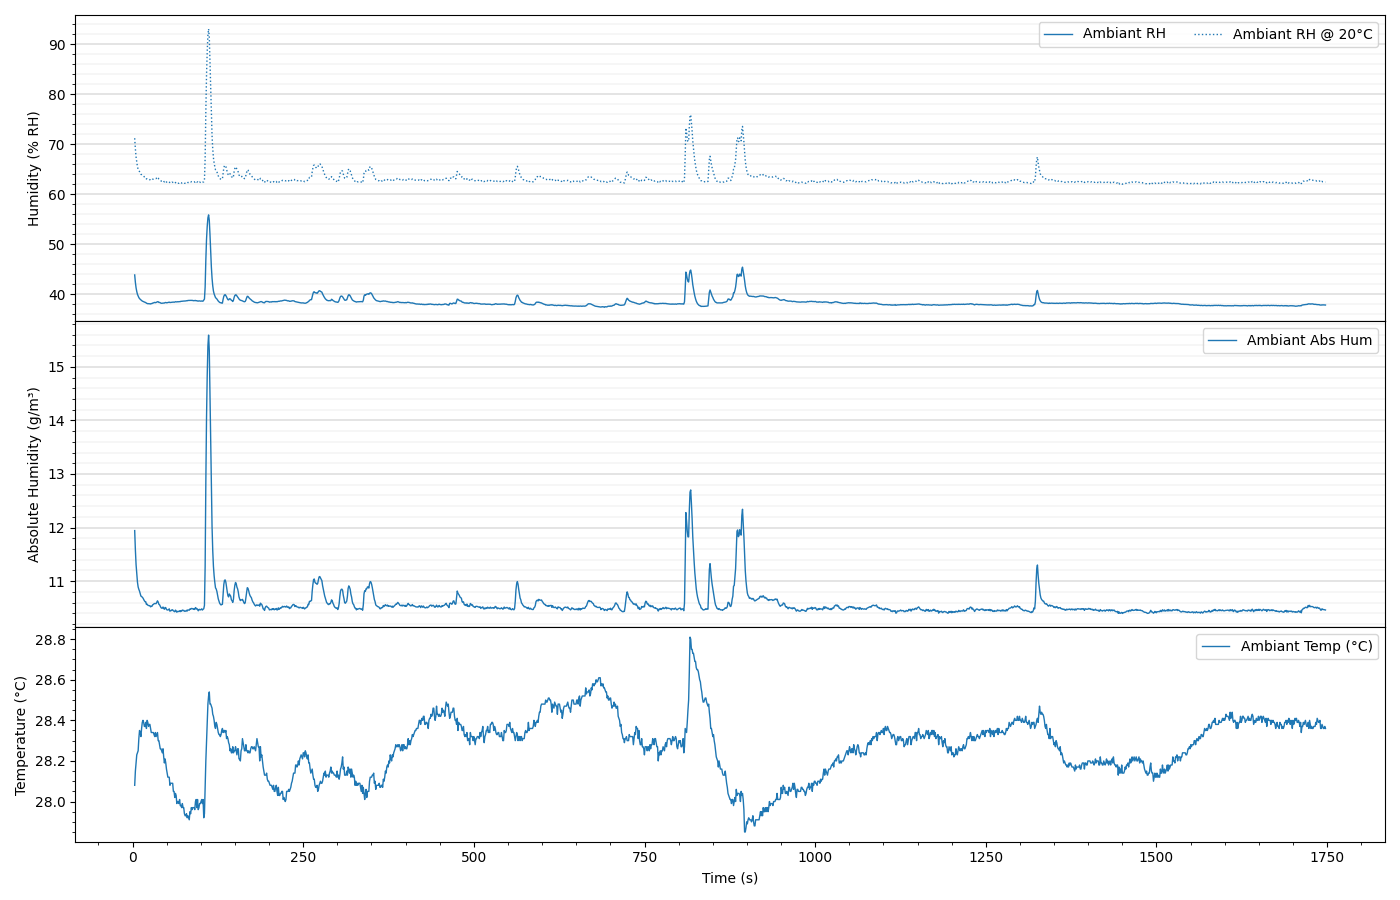

Animation started. Monitoring file: sensor_readings_20250627_162314.csv


In [14]:
%matplotlib ipympl

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
import matplotlib as mpl
from io import StringIO

filename = 'sensor_readings_20250627_162314.csv'
# MAX_POINTS = 1000
MAX_POINTS = -1

# Configuration from cell 2
serial_to_name = {
    "sensor_readings_20250620_125414.csv": {
        "0xF030D05B_blue": "Box",
        "0xF030D0CF_red": "House air",
        "0xEFCF86D7_yellow": "Ambiant"
    },
    "sensor_readings_20250623_140525.csv": {
        "0xF030D05B_blue": "Robot arm",
        "0xF030D0CF_red": "CBox carrier",
        "0xEFCF86D7_yellow": "Ambiant"
    },
    "sensor_readings_20250627_121615.csv": {
        "0xF030D05B_blue": "Robot arm",
        "0xF030D0CF_red": "Spin coater 2",
        "0xEFCF86D7_yellow": "Ambiant"
    },
    "sensor_readings_20250627_162314.csv": {
        "0xEFCF86D7_yellow": "Ambiant"
    }
}


def calc_absolute_humidity(temp_c, rh):
    return 216.7 * (rh / 100.0 * 6.112 * np.exp(17.62 * temp_c / (243.12 + temp_c)) / (273.15 + temp_c))

def calc_relative_humidity(rh, temp_c, target_temp_c):
    return rh * np.exp(4283.78 * (temp_c - target_temp_c) / (243.12 + temp_c) / (243.12 + target_temp_c))

def read_last_n_lines(filename, n=3):
    """Read the last n lines from a file"""
    try:
        with open(filename, 'rb') as f:
            f.seek(0, 2)  # Go to end of file
            file_size = f.tell()
            
            if file_size == 0:
                return []
            
            # Start from end and work backwards
            lines = []
            buffer = b''
            position = file_size
            
            while len(lines) < n and position > 0:
                # Read in chunks
                chunk_size = min(1024, position)
                position -= chunk_size
                f.seek(position)
                chunk = f.read(chunk_size)
                buffer = chunk + buffer
                
                # Split into lines
                temp_lines = buffer.split(b'\n')
                buffer = temp_lines[0]  # Keep incomplete line at start
                
                # Add complete lines to our list (in reverse order)
                for line in reversed(temp_lines[1:]):
                    if line.strip():  # Skip empty lines
                        lines.insert(0, line.decode('utf-8'))
                        if len(lines) >= n:
                            break
            
            return lines[-n:] if len(lines) > n else lines
    except (FileNotFoundError, IOError):
        return []

# Global data storage
data_buffer = {}
headers = None
last_timestamps = set()
serials = set()

# Set up the figure and axes like in cell 2
fig, (ax_rh, ax_ah, ax_temp) = plt.subplots(
    3, 1, figsize=(14, 9), sharex=True, gridspec_kw={'height_ratios': [1, 1, 0.7], 'hspace': 0}
)

colors = mpl.cm.tab10(range(10))

# Initialize empty line objects for each sensor
lines_ah = {}
lines_rh = {}
lines_rh_20c = {}
lines_temp = {}

# Read initial CSV to get headers and load existing data
try:
    df_initial = pd.read_csv(filename)
    headers = df_initial.columns.tolist()
    
    for col in headers:
        if '_temperature' in col:
            serials.add(col.replace('_temperature (degrees C)', ''))
    
    # Initialize line objects and load existing data
    for i, serial in enumerate(serials):
        sensor_name = serial_to_name.get(filename, {}).get(serial, serial)
        color = colors[i % len(colors)]
        
        lines_ah[serial], = ax_ah.plot([], [], label=f"{sensor_name} Abs Hum", color=color, linewidth=1, linestyle='-')
        lines_rh[serial], = ax_rh.plot([], [], label=f"{sensor_name} RH", linewidth=1, color=color, linestyle='-')
        lines_rh_20c[serial], = ax_rh.plot([], [], label=f"{sensor_name} RH @ 20°C", linewidth=1, color=color, linestyle=':')
        lines_temp[serial], = ax_temp.plot([], [], label=f"{sensor_name} Temp (°C)", linewidth=1, color=color)
        
        # Initialize data buffer and load existing data
        temp_col = f"{serial}_temperature (degrees C)"
        hum_col = f"{serial}_humidity (% rH)"
        
        if temp_col in df_initial.columns and hum_col in df_initial.columns:
            valid = df_initial[['timestamp', temp_col, hum_col]].dropna()
            if not valid.empty:
                valid['time_s'] = valid['timestamp'] / 1000.0
                
                abs_hum = calc_absolute_humidity(valid[temp_col], valid[hum_col])
                rh_20c = calc_relative_humidity(valid[hum_col], valid[temp_col], 20.0)
                
                data_buffer[serial] = {
                    'time_s': valid['time_s'].tolist(),
                    'temperature': valid[temp_col].tolist(),
                    'humidity': valid[hum_col].tolist(),
                    'abs_hum': abs_hum.tolist(),
                    'rh_20c': rh_20c.tolist()
                }
                
                # Update timestamp tracking
                last_timestamps.update(valid['timestamp'].tolist())
                
                # Set initial data
                lines_ah[serial].set_data(data_buffer[serial]['time_s'], data_buffer[serial]['abs_hum'])
                lines_rh[serial].set_data(data_buffer[serial]['time_s'], data_buffer[serial]['humidity'])
                lines_rh_20c[serial].set_data(data_buffer[serial]['time_s'], data_buffer[serial]['rh_20c'])
                lines_temp[serial].set_data(data_buffer[serial]['time_s'], data_buffer[serial]['temperature'])
            else:
                data_buffer[serial] = {
                    'time_s': [],
                    'temperature': [],
                    'humidity': [],
                    'abs_hum': [],
                    'rh_20c': []
                }

except FileNotFoundError:
    print(f"File {filename} not found. Will wait for it to be created.")
    headers = None

# Set up axes labels and legends
ax_ah.set_ylabel('Absolute Humidity (g/m³)')
ax_rh.set_ylabel('Humidity (% RH)')
ax_temp.set_xlabel('Time (s)')
ax_temp.set_ylabel('Temperature (°C)')

ax_ah.legend()
ax_rh.legend(ncol=3)
ax_temp.legend()

ax_temp.minorticks_on()
ax_rh.minorticks_on()
ax_ah.minorticks_on()

ax_rh.grid(visible=True, which='major', axis='y', color='gray', linestyle='-', linewidth=0.3)
ax_rh.grid(visible=True, which='minor', axis='y', color='gray', linestyle='-', linewidth=0.1)
ax_ah.grid(visible=True, which='major', axis='y', color='gray', linestyle='-', linewidth=0.3)
ax_ah.grid(visible=True, which='minor', axis='y', color='gray', linestyle='-', linewidth=0.1)

# Auto-scale axes initially
if data_buffer:
    ax_ah.relim()
    ax_ah.autoscale_view()
    ax_rh.relim()
    ax_rh.autoscale_view()
    ax_temp.relim()
    ax_temp.autoscale_view()

def data_generator():
    """Generator that yields new data from CSV file"""
    global headers, last_timestamps
    
    while True:
        # Read headers if not available
        if headers is None:
            try:
                df_temp = pd.read_csv(filename, nrows=0)
                headers = df_temp.columns.tolist()
                print("Headers loaded:", headers)
            except (FileNotFoundError, pd.errors.EmptyDataError):
                print("Waiting for file...")
                yield None
                continue
        
        # Read last 3 lines
        lines = read_last_n_lines(filename, len(serials) + 1)
        
        if not lines:
            yield None
            continue
        
        # Parse lines into DataFrame
        csv_string = ','.join(headers) + '\n' + '\n'.join(lines)
        try:
            df_new = pd.read_csv(StringIO(csv_string))
            
            # Remove duplicates based on timestamp
            df_new = df_new.drop_duplicates(subset=['timestamp'], keep='last')
            
            # Filter out timestamps we've already seen
            new_data = df_new[~df_new['timestamp'].isin(last_timestamps)]
            
            if not new_data.empty:
                print(f"New data points: {len(new_data)}")
                # Update timestamp tracking
                last_timestamps.update(new_data['timestamp'].tolist())
                # Keep only recent timestamps to prevent memory growth
                if len(last_timestamps) > 1000:
                    sorted_timestamps = sorted(last_timestamps)
                    last_timestamps = set(sorted_timestamps[-500:])
                
                yield new_data
            else:
                yield None
                
        except (pd.errors.ParserError, ValueError) as e:
            print(f"Parse error: {e}")
            yield None

# Data update function
def update_plot(new_data):
    global data_buffer, serials
    
    if new_data is None or new_data.empty:
        return list(lines_ah.values()) + list(lines_rh.values()) + list(lines_rh_20c.values()) + list(lines_temp.values())
    
    try:
        new_data['time_s'] = new_data['timestamp'] / 1000.0
        
        # Get current serials from new data
        current_serials = set()
        for col in new_data.columns:
            if '_temperature' in col:
                current_serials.add(col.replace('_temperature (degrees C)', ''))
        
        # Add new sensors if they appear
        for serial in current_serials - serials:
            sensor_name = serial_to_name.get(filename, {}).get(serial, serial)
            color = colors[len(lines_ah) % len(colors)]
            
            lines_ah[serial], = ax_ah.plot([], [], label=f"{sensor_name} Abs Hum", color=color, linewidth=1, linestyle='-')
            lines_rh[serial], = ax_rh.plot([], [], label=f"{sensor_name} RH", linewidth=1, color=color, linestyle='-')
            lines_rh_20c[serial], = ax_rh.plot([], [], label=f"{sensor_name} RH @ 20°C", linewidth=1, color=color, linestyle=':')
            lines_temp[serial], = ax_temp.plot([], [], label=f"{sensor_name} Temp (°C)", linewidth=1, color=color)
            
            # Initialize data buffer for new sensor
            data_buffer[serial] = {
                'time_s': [],
                'temperature': [],
                'humidity': [],
                'abs_hum': [],
                'rh_20c': []
            }
            
            # Update legends
            ax_ah.legend()
            ax_rh.legend(ncol=3)
            ax_temp.legend()
        
        serials.update(current_serials)
        
        # Process new data for each sensor
        for serial in current_serials:
            temp_col = f"{serial}_temperature (degrees C)"
            hum_col = f"{serial}_humidity (% rH)"
            
            if temp_col in new_data.columns and hum_col in new_data.columns:
                # Get valid new data points
                valid_mask = new_data[temp_col].notna() & new_data[hum_col].notna()
                valid_new = new_data[valid_mask]
                
                if not valid_new.empty:
                    # Calculate derived values
                    abs_hum = calc_absolute_humidity(valid_new[temp_col], valid_new[hum_col])
                    rh_20c = calc_relative_humidity(valid_new[hum_col], valid_new[temp_col], 20.0)
                    
                    # Append to buffer
                    data_buffer[serial]['time_s'].extend(valid_new['time_s'].tolist())
                    data_buffer[serial]['temperature'].extend(valid_new[temp_col].tolist())
                    data_buffer[serial]['humidity'].extend(valid_new[hum_col].tolist())
                    data_buffer[serial]['abs_hum'].extend(abs_hum.tolist())
                    data_buffer[serial]['rh_20c'].extend(rh_20c.tolist())
                    
                    # Keep only recent data (last MAX_POINTS points to prevent memory issues)
                    if MAX_POINTS > 0:
                        for key in data_buffer[serial]:
                            if len(data_buffer[serial][key]) > MAX_POINTS:
                                data_buffer[serial][key] = data_buffer[serial][key][-MAX_POINTS:]
                    
                    # Update line data
                    lines_ah[serial].set_data(data_buffer[serial]['time_s'], data_buffer[serial]['abs_hum'])
                    lines_rh[serial].set_data(data_buffer[serial]['time_s'], data_buffer[serial]['humidity'])
                    lines_rh_20c[serial].set_data(data_buffer[serial]['time_s'], data_buffer[serial]['rh_20c'])
                    lines_temp[serial].set_data(data_buffer[serial]['time_s'], data_buffer[serial]['temperature'])
        
        # Auto-scale axes
        ax_ah.relim()
        ax_ah.autoscale_view()
        ax_rh.relim()
        ax_rh.autoscale_view()
        ax_temp.relim()
        ax_temp.autoscale_view()
        
    except (KeyError, ValueError) as e:
        print(f"Error processing data: {e}")
        pass
    
    return list(lines_ah.values()) + list(lines_rh.values()) + list(lines_rh_20c.values()) + list(lines_temp.values())

# Create animation with data generator
ani = animation.FuncAnimation(fig, update_plot, frames=data_generator, interval=1000, blit=False, cache_frame_data=False)

plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.show()

print(f"Animation started. Monitoring file: {filename}")